In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

# Using GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Setting hyper parameters
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [3]:
# Getting data ready
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]


In [4]:
class Neural_Network(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Neural_Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [11]:
model = Neural_Network(input_size, hidden_size, num_classes).to(device)
model.initialize_weights()

# Training Loop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # enumerate used to get batch index
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device).reshape(data.shape[0], -1)
        targets = targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_function(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    # We don't need gradients because we're not training
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.reshape(data.shape[0], -1).to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = loss_function(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    # Save metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(100 * train_correct / train_total)
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_losses[-1]:.3f}, Val Loss={val_losses[-1]:.3f}')

Epoch 1/20: Train Loss=0.828, Val Loss=0.422
Epoch 2/20: Train Loss=0.370, Val Loss=0.329
Epoch 3/20: Train Loss=0.308, Val Loss=0.288
Epoch 4/20: Train Loss=0.273, Val Loss=0.262
Epoch 5/20: Train Loss=0.248, Val Loss=0.245
Epoch 6/20: Train Loss=0.228, Val Loss=0.228
Epoch 7/20: Train Loss=0.212, Val Loss=0.217
Epoch 8/20: Train Loss=0.198, Val Loss=0.203
Epoch 9/20: Train Loss=0.186, Val Loss=0.195
Epoch 10/20: Train Loss=0.175, Val Loss=0.186
Epoch 11/20: Train Loss=0.166, Val Loss=0.181
Epoch 12/20: Train Loss=0.157, Val Loss=0.175
Epoch 13/20: Train Loss=0.150, Val Loss=0.168
Epoch 14/20: Train Loss=0.143, Val Loss=0.166
Epoch 15/20: Train Loss=0.136, Val Loss=0.158
Epoch 16/20: Train Loss=0.131, Val Loss=0.155
Epoch 17/20: Train Loss=0.125, Val Loss=0.151
Epoch 18/20: Train Loss=0.121, Val Loss=0.148
Epoch 19/20: Train Loss=0.116, Val Loss=0.144
Epoch 20/20: Train Loss=0.112, Val Loss=0.140


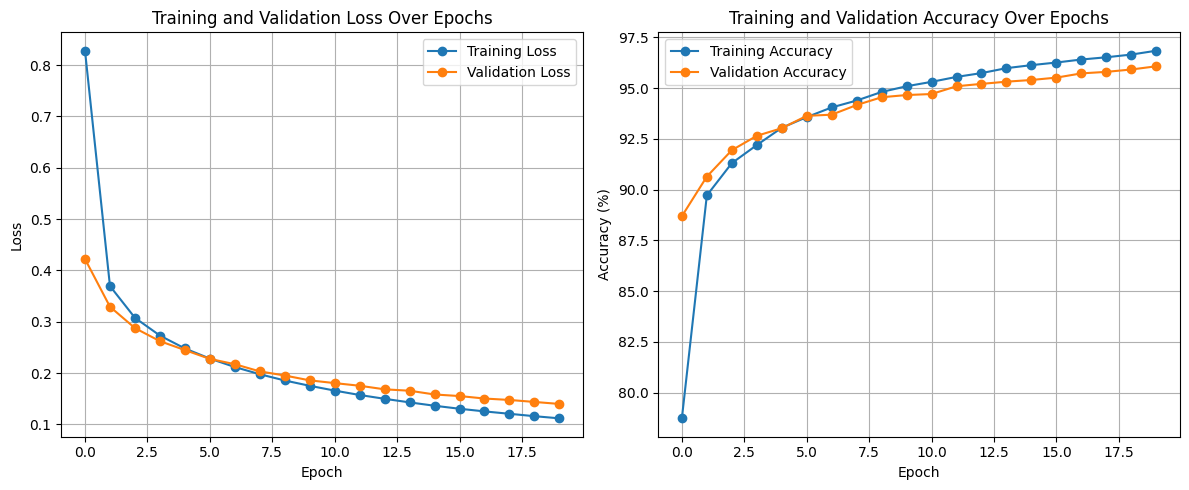


=== Convergence Analysis ===
Final Training Loss: 0.1120
Final Validation Loss: 0.1400
Final Training Accuracy: 96.84%
Final Validation Accuracy: 96.08%
Model converged after 20 epochs


In [12]:
# Plotting

plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n=== Convergence Analysis ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Model converged after {num_epochs} epochs")